# End to End Matching Example

Please run [Record-Linkage-Example.ipynb](Record-Linkage-Example.ipynb) before this one in order to get the trained model at `../trained-models/notebooks/rl/rl-model.ckpt`.

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Loading Test Data

In [6]:
import json
from ordered_set import OrderedSet

def load_pair_set(filepath):
    with open(filepath, 'r') as f:
        test_pos_pair_set = json.load(f)
        return OrderedSet(tuple(pair) for pair in test_pos_pair_set)

train_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-train-pos-pairs.json')
valid_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-valid-pos-pairs.json')
test_pos_pair_set = load_pair_set('../trained-models/notebooks/rl/rl-test-pos-pairs.json')

In [7]:
import json

def load_record_dict(filepath):
    with open(filepath, 'r') as f:
        record_dict = json.load(f)
        return {int(id_): record for id_, record in record_dict.items()}

train_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-train-records.json')
valid_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-valid-records.json')
test_record_dict = load_record_dict('../trained-models/notebooks/rl/rl-test-records.json')

## Loading Model

In [8]:
from entity_embed import LinkageEmbed

model = LinkageEmbed.load_from_checkpoint('../trained-models/notebooks/rl/rl-model.ckpt')

## Blocking

In [9]:
%%time

eval_batch_size = 64
ann_k = 100
sim_threshold = 0.3

train_found_pair_set = model.predict_pairs(
    record_dict=train_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
)

# batch embedding:   0%|          | 0/44 [00:00<?, ?it/s]

CPU times: user 1min 42s, sys: 3.41 s, total: 1min 46s
Wall time: 18.5 s


In [10]:
%%time

valid_found_pair_set = model.predict_pairs(
    record_dict=valid_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 31.1 s, sys: 879 ms, total: 31.9 s
Wall time: 5.85 s


In [11]:
%%time

test_found_pair_set = model.predict_pairs(
    record_dict=test_record_dict,
    batch_size=eval_batch_size,
    ann_k=ann_k,
    sim_threshold=sim_threshold,
    show_progress=True,
)

# batch embedding:   0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 27.1 s, sys: 1.01 s, total: 28.1 s
Wall time: 5.19 s


In [12]:
from entity_embed.evaluation import pair_entity_ratio

pair_entity_ratio(len(test_found_pair_set), len(test_record_dict))

3.144273127753304

In [13]:
from entity_embed.evaluation import precision_and_recall

precision_and_recall(test_found_pair_set, test_pos_pair_set)

(0.087215411558669, 0.996)

## Matching: Compare

Make a dataframe `df` with all records (train, valid, test) to add additional features:

In [14]:
record_dict = {**train_record_dict, **valid_record_dict, **test_record_dict}

In [15]:
import pandas as pd

df = pd.DataFrame.from_dict(record_dict, orient='index')
df = df.drop(columns='id')

In [16]:
df['all'] = df.agg('{0[name]} - {0[description]} - {0[manufacturer]} - {0[price]}'.format, axis=1)
df['price'] = pd.to_numeric(df['price'].str.replace(' ', ''), errors='coerce')
df.head(3)

,name,description,manufacturer,price,__source,cluster,all
1728,filemaker pro 8 . 5 5 - user pack,system requirements macintosh macintosh comput...,,1149.00,google,1561,filemaker pro 8 . 5 5 - user pack - system req...
255,diskeeper 2007 pro premier 5 - lic pack,- marketing information : diskeeper pro premie...,diskeeper corporation,736.66,amazon,1207,diskeeper 2007 pro premier 5 - lic pack - - ma...
2889,emc securid appl mnt - ent / std 17mo per u 2k...,,,16.00,google,2231,emc securid appl mnt - ent / std 17mo per u 2k...


Replace all `record_dict`s (train, valid, test) to add additional features:

In [17]:
train_record_dict = df.loc[train_record_dict.keys()].to_dict(orient='index')
valid_record_dict = df.loc[valid_record_dict.keys()].to_dict(orient='index')
test_record_dict = df.loc[test_record_dict.keys()].to_dict(orient='index')

del df

In [18]:
import textdistance as td
import math

def token_ops(func):
    def new_func(x, y):
        return func(x.split(), y.split())    
    return new_func

def empty_str(x, y):
    return int(not x or not y)

def empty_num(x, y):
    return int(not x or not y or math.isnan(x) or math.isnan(y))

def zero_if_empty(x):
    if not x or math.isnan(x):
        return 0
    else:
        return x

def abs_diff(x, y):
    return abs(zero_if_empty(x) - zero_if_empty(y))

def abs_diff_log10(x, y, min_val=math.log10(1e-5)):
    diff = abs_diff(x, y)
    if diff > 0:
        return max(math.log10(diff), min_val)
    else:
        return min_val

SIM_FUNC_DICT = {
    ("all", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("all", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("all", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("all", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("description", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("description", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("description", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("description", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("manufacturer", "empty_str"): empty_str,
    ("manufacturer", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("manufacturer", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("manufacturer", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("manufacturer", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("name", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("name", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("name", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("name", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("price", "empty_num"): empty_num,
    ("price", "abs_diff"): abs_diff,
    ("price", "abs_diff_log10"): abs_diff_log10,
}

def record_sim_func(record_pair):
    record_left, record_right = record_pair
    feature_dict = {}
    
    for (field, sim_func_name), sim_func in SIM_FUNC_DICT.items():
        sim = sim_func(record_left[field], record_right[field])
        feature_dict[f"{field}_{sim_func_name}"] = sim
    
    return feature_dict

In [19]:
%%time

pair = next(iter(test_pos_pair_set))
id_left, id_right = pair
feature_dict = record_sim_func((test_record_dict[id_left], test_record_dict[id_right]))

# display(test_record_dict[id_left], test_record_dict[id_right])
feature_dict

CPU times: user 2.46 ms, sys: 112 µs, total: 2.57 ms
Wall time: 2.27 ms


{'all_jaccard': 0.10606060606060608,
 'all_overlap': 0.4375,
 'all_damerau_levenshtein': 0.21246006389776362,
 'all_jaro_winkler': 0.5891946976977757,
 'description_jaccard': 0.0431034482758621,
 'description_overlap': 0.23809523809523814,
 'description_damerau_levenshtein': 0.15752212389380527,
 'description_jaro_winkler': 0.5512834662810849,
 'manufacturer_empty_str': 1,
 'manufacturer_jaccard': 0.0,
 'manufacturer_overlap': 0.0,
 'manufacturer_damerau_levenshtein': 0.0,
 'manufacturer_jaro_winkler': 0.0,
 'name_jaccard': 0.7142857142857143,
 'name_overlap': 1.0,
 'name_damerau_levenshtein': 0.8888888888888888,
 'name_jaro_winkler': 0.9652777777777778,
 'price_empty_num': 0,
 'price_abs_diff': 14.709999999999994,
 'price_abs_diff_log10': 1.16761267272753}

In [20]:
from collections import defaultdict
import multiprocessing
from tqdm.auto import tqdm

def compare_pairs(record_dict, found_pair_set):
    all_feature_dict = defaultdict(list)
    chunksize = 100
    tasks = (
        (record_dict[id_left], record_dict[id_right])
        for (id_left, id_right)
        in found_pair_set
    )

    with multiprocessing.Pool() as pool:
        for feature_dict in tqdm(
            pool.imap(record_sim_func, tasks, chunksize=chunksize),
            total=len(found_pair_set)
        ):
            for feature, val in feature_dict.items():
                all_feature_dict[feature].append(val)

        pool.close()
        pool.join()
    
    return pd.DataFrame(all_feature_dict, index=pd.MultiIndex.from_tuples(found_pair_set))

In [21]:
%%time

train_feature_df = compare_pairs(train_record_dict, train_found_pair_set)
assert len(train_feature_df) == len(train_found_pair_set)
len(train_found_pair_set)

  0%|          | 0/20227 [00:00<?, ?it/s]

CPU times: user 1.21 s, sys: 240 ms, total: 1.45 s
Wall time: 5.39 s


20227

In [22]:
%%time

valid_feature_df = compare_pairs(valid_record_dict, valid_found_pair_set)
assert len(valid_feature_df) == len(valid_found_pair_set)
len(valid_found_pair_set)

  0%|          | 0/2557 [00:00<?, ?it/s]

CPU times: user 134 ms, sys: 88.9 ms, total: 222 ms
Wall time: 917 ms


2557

In [23]:
%%time

test_feature_df = compare_pairs(test_record_dict, test_found_pair_set)
assert len(test_feature_df) == len(test_found_pair_set)
len(test_found_pair_set)

  0%|          | 0/2855 [00:00<?, ?it/s]

CPU times: user 146 ms, sys: 108 ms, total: 255 ms
Wall time: 980 ms


2855

## Matching: Compare - Additional Features

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_vectorizer(train_record_dict, valid_record_dict, field='all'):
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2,4),
        min_df=2
    )
    train_valid_record_dict = {**train_record_dict, **valid_record_dict}
    tfidf_vectorizer.fit(record[field] for record in train_valid_record_dict.values())
    return tfidf_vectorizer

tfidf_vectorizer = get_tfidf_vectorizer(train_record_dict, valid_record_dict)
tfidf_vectorizer

TfidfVectorizer(analyzer='char', min_df=2, ngram_range=(2, 4))

In [25]:
import numpy as np

def add_tfidf_feature(feature_df, record_dict, found_pair_set, field='all'):
    tfidf_matrix = tfidf_vectorizer.transform(record[field] for record in record_dict.values())

    id_to_idx = {id_: idx for idx, id_ in enumerate(record_dict.keys())}
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    tfidf_sim = tfidf_matrix[left_idx].multiply(tfidf_matrix[right_idx]).sum(axis=1)

    feature_df[f'{field}_tfidf'] = tfidf_sim

In [26]:
%%time

add_tfidf_feature(train_feature_df, train_record_dict, train_found_pair_set)

CPU times: user 1.16 s, sys: 52 ms, total: 1.21 s
Wall time: 1.21 s


In [27]:
%%time

add_tfidf_feature(valid_feature_df, valid_record_dict, valid_found_pair_set)

CPU times: user 345 ms, sys: 4.05 ms, total: 349 ms
Wall time: 349 ms


In [28]:
%%time

add_tfidf_feature(test_feature_df, test_record_dict, test_found_pair_set)

CPU times: user 345 ms, sys: 4.04 ms, total: 349 ms
Wall time: 349 ms


## Matching: Classify

In [29]:
train_valid_feature_df = pd.concat([train_feature_df, valid_feature_df])
train_valid_feature_df.head(3)

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,description_jaccard,description_overlap,description_damerau_levenshtein,description_jaro_winkler,manufacturer_empty_str,manufacturer_jaccard,...,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,name_jaccard,name_overlap,name_damerau_levenshtein,name_jaro_winkler,price_empty_num,price_abs_diff,price_abs_diff_log10,all_tfidf
1169,2516,0.209790,0.535714,0.311321,0.669970,0.146341,0.439024,0.278169,0.655704,1,0.0,...,0.0,0.0,0.500000,0.666667,0.666667,0.835480,0,0.00,-5.000000,0.410840
1186,1931,0.079268,0.206349,0.234247,0.597061,0.033784,0.094340,0.212575,0.593720,1,0.0,...,0.0,0.0,0.181818,0.500000,0.400000,0.828095,0,899.01,2.953765,0.181396
324,4410,0.131868,0.375000,0.238307,0.571359,0.072464,0.333333,0.161538,0.541650,1,0.0,...,0.0,0.0,0.076923,0.333333,0.228571,0.550288,0,12.02,1.079904,0.223682


In [30]:
train_true_y = np.array([pair in train_pos_pair_set for pair in train_found_pair_set], dtype='i4')
valid_true_y = np.array([pair in valid_pos_pair_set for pair in valid_found_pair_set], dtype='i4')
test_true_y = np.array([pair in test_pos_pair_set for pair in test_found_pair_set], dtype='i4')

In [31]:
train_valid_true_y = np.concatenate([train_true_y, valid_true_y])

In [32]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=random_seed)
clf.fit(train_valid_feature_df, train_valid_true_y)

CPU times: user 5.76 s, sys: 45.7 ms, total: 5.81 s
Wall time: 788 ms


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [33]:
if hasattr(clf, 'oob_score_'):
    clf.oob_score_

In [34]:
try:
    feature_importances = dict(zip(train_valid_feature_df.columns, clf.feature_importances_))
    sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)
except AttributeError:
    pass

In [35]:
from sklearn.metrics import accuracy_score

cls_threshold = sim_threshold
train_valid_pred_y = clf.predict_proba(train_valid_feature_df)
train_valid_pred_y[train_valid_pred_y >= cls_threshold] = 1
train_valid_pred_y[train_valid_pred_y < cls_threshold] = 0
train_valid_pred_y = train_valid_pred_y[:, 1]
accuracy_score(train_valid_pred_y, train_valid_true_y)

0.9978932584269663

In [36]:
from sklearn.metrics import precision_recall_fscore_support

pred_y = clf.predict_proba(test_feature_df)
pred_y[pred_y >= cls_threshold] = 1
pred_y[pred_y < cls_threshold] = 0
pred_y = pred_y[:, 1]
precision_recall_fscore_support(test_true_y, pred_y, labels=[1])

(array([0.75918367]), array([0.74698795]), array([0.75303644]), array([249]))

In [37]:
cls_found_pair_set = OrderedSet(test_feature_df[pred_y.astype(bool)].index)

precision_and_recall(cls_found_pair_set, test_pos_pair_set)

(0.7591836734693878, 0.744)

False negatives:

In [38]:
for x, y in list(test_pos_pair_set - cls_found_pair_set)[:10]:
    display(((x, y), test_record_dict[x]['name'], test_record_dict[y]['name']))

((774, 1730),
 'adobe software acrobat pro upgrd pro - pro mac ( adbcd01798mc )',
 'adobe acrobat v8 . 0 professional for mac upgrade')

((598, 2318),
 'adobe pagemaker v7 . 0 . 2 cd mac - upg ( 17530402 )',
 'adobe pagemaker 7 . 0 for mac version upgrade')

((784, 3940),
 "axis & allies collector ' s edition",
 'encore software 11430 - axis & allies collectors edition - win 98 me 2000 xp')

((1032, 3688),
 'finale allegro 2007',
 'make finale allegro software music production software')

((644, 1693),
 'microspot macdraft pe ( mac )',
 'microspot macdraft pe personal edition')

((199, 1428),
 'netmanage upg rumba unix - hp edition level ( 902453 - 007 - c )',
 '902453 - 007 - b rumba unix - hp edition - upgrade license - 1 user - volume - level b ( 5 - 49 ) - c')

((243, 1504),
 'money premium 2007 win32 eng na mini box us only cd',
 'money prem 2007 cd minibox')

((1350, 1958), 'train sim modeler design studio', 'abacus train sim modeler')

((852, 3805),
 'cinescore professional soundtrack edition',
 'sony media software cinescore soundtrack creation software audio software for video')

((771, 1729),
 "e frontier poser 6 collector ' s edition with volume 1 figure pack ( mac )",
 'allume poser 6 for mac')

In [39]:
clf.predict_proba(test_feature_df.loc[[pair]])

array([[0.13, 0.87]])

<Figure size 1152x720 with 0 Axes>

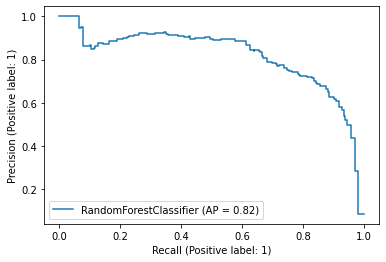

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(16,10))

disp = plot_precision_recall_curve(clf, test_feature_df, test_true_y)